In [1]:
import scipy.io
data = scipy.io.loadmat('Data_ankle.mat')
ankle_data= data['ankle_data']
print(ankle_data.shape)

(48000, 7)


In [2]:
import pandas as pd
# Define column names
column_names = [
    'time', 
    'vgrf',  # vertical ground reaction force
    'trunk_angle',
    'hip_angle', 
    'knee_angle', 
    'ankle_angle', 
    'joint_moment'
]


In [3]:
df = pd.DataFrame(ankle_data, columns=column_names )
df.head()

,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [4]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [5]:
# Separate the features and target variable
X_train = train_data.drop(columns=['time', 'joint_moment'])
Y_train = train_data['joint_moment'].values.reshape(-1, 1)  # Reshape for scaler
X_test = test_data.drop(columns=['time', 'joint_moment'])
Y_test = test_data['joint_moment'].values.reshape(-1, 1)  # Reshape for scaler

In [6]:
from sklearn.preprocessing import StandardScaler
# Apply scaling only to the training data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler to transform the test data

In [7]:
# Apply scaling to the target variable
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Fit and transform the training target variable
Y_test_scaled = scaler_Y.transform(Y_test)  # Transform the test target variable using the same scaler

print(Y_test_scaled)

[[-0.98351688]
 [-0.98411872]
 [-0.96365408]
 ...
 [ 0.30780874]
 [ 0.34680355]
 [ 0.37615492]]


In [8]:
# Convert scaled data back to DataFrame
normalized_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
normalized_train_df['time'] = train_data['time'].reset_index(drop=True)
normalized_train_df['joint_moment'] = Y_train_scaled.flatten()  # Flatten to 1D

normalized_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
normalized_test_df['time'] = test_data['time'].reset_index(drop=True)
normalized_test_df['joint_moment'] = Y_test_scaled.flatten()  # Flatten to 1D

In [9]:
# Print the normalized data
print(train_data.head())
print(test_data.head())

# If you need to access the target variable from the test data separately
target_Ytest_normalized = normalized_test_df['joint_moment']
print(target_Ytest_normalized.head())

   time       vgrf  trunk_angle  hip_angle  knee_angle  ankle_angle  \
0  0.00 -10.321381    -0.094286   0.292974    0.825063    -1.492588   
1  0.01  -7.990312    -0.096174   0.293179    0.822469    -1.493192   
2  0.02  -6.208738    -0.096449   0.294008    0.810997    -1.495867   
3  0.03  -5.126637    -0.097196   0.295568    0.785731    -1.501793   
4  0.04  -4.774037    -0.095624   0.297472    0.745707    -1.511208   

   joint_moment  
0     -2.011628  
1     -3.655209  
2     -5.786433  
3     -6.190008  
4     -5.542868  
         time       vgrf  trunk_angle  hip_angle  knee_angle  ankle_angle  \
38400  384.00 -11.512108    -0.032512   0.007387    0.973938    -1.273562   
38401  384.01 -15.839764    -0.035124   0.037376    1.022451    -1.272575   
38402  384.02 -16.915961    -0.038637   0.066333    1.062992    -1.280968   
38403  384.03 -15.981315    -0.044385   0.093862    1.094613    -1.295619   
38404  384.04 -13.927180    -0.048895   0.119811    1.116854    -1.313351   

  

In [10]:
def extract_data_for_combination(columns):
    X_train = normalized_train_df[columns].values
    y_train = normalized_train_df['joint_moment'].values
    X_test = normalized_test_df[columns].values
    y_test = normalized_test_df['joint_moment'].values
    
    # Reshape for RNN
    X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Reshape for CNN
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train_rnn, y_train, X_test_rnn, y_test, X_train_cnn, X_test_cnn


In [11]:
from keras.models import Sequential
from keras.layers import  Dense, Dropout , LSTM ,  BatchNormalization

# Hyperparameters were set based on Optuna outputs


def create_rnn_model(input_shape):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(87, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.28))
    
    # Second LSTM layer
    model.add(LSTM(87, activation='relu'))
    model.add(Dropout(0.28))
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Dense layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [12]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization

def create_cnn_model(input_shape):
    model = Sequential()
    
    # First Conv1D layer with kernel size 1
    model.add(Conv1D(filters=99, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.1))
    
    # Second Conv1D layer with kernel size 1
    model.add(Conv1D(filters=99, kernel_size=1, activation='relu'))
    model.add(Dropout(0.1))
    
    # Flatten layer
    model.add(Flatten())
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Dense layer
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model



In [13]:
from sklearn.metrics import mean_squared_error
import os 

def train_and_evaluate_rnn_model(input_comb, model_path):
    X_train_rnn, y_train, X_test_rnn, y_test, _, _ = extract_data_for_combination(input_comb)
    rnn_model = create_rnn_model(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
    history = rnn_model.fit(X_train_rnn, y_train, epochs=54, batch_size=80, validation_split=0.2, verbose=1)
    predictions = rnn_model.predict(X_test_rnn).flatten()
    mse = mean_squared_error(y_test, predictions)
    rnn_model.save(model_path)
    return mse, predictions, history

In [14]:
def train_and_evaluate_cnn_model(input_comb, model_path):
    _, y_train, _, y_test, X_train_cnn, X_test_cnn = extract_data_for_combination(input_comb)
    cnn_model = create_cnn_model(input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
    history = cnn_model.fit(X_train_cnn, y_train, epochs=54, batch_size=80, validation_split=0.2, verbose=1)
    predictions = cnn_model.predict(X_test_cnn).flatten()
    mse = mean_squared_error(y_test, predictions)
    cnn_model.save(model_path)
    return mse, predictions, history

In [15]:
# Directory to save the models
model_dir = 'models/'
os.makedirs(model_dir, exist_ok=True)

# Define input combinations
input_combinations = {
    'all_angles_and_vgrf': ['vgrf', 'trunk_angle', 'hip_angle', 'knee_angle', 'ankle_angle'],
    'ankle_angle_only': ['ankle_angle'],
    'feature_importance': ['vgrf', 'hip_angle','ankle_angle'],
}

results = {}
for key, columns in input_combinations.items():

      # CNN Model
    cnn_model_path = os.path.join(model_dir, f"cnn_model_{key}.h5")
    cnn_mse, cnn_predictions, cnn_history = train_and_evaluate_cnn_model(columns, cnn_model_path)
    
    # RNN Model
    rnn_model_path = os.path.join(model_dir, f"rnn_model_{key}.h5")
    rnn_mse, rnn_predictions, rnn_history = train_and_evaluate_rnn_model(columns, rnn_model_path)
    
  
    
    results[key] = {
        'rnn_mse': rnn_mse,
        'rnn_predictions': rnn_predictions,
        'rnn_history': rnn_history,
        'cnn_mse': cnn_mse,
        'cnn_predictions': cnn_predictions,
        'cnn_history': cnn_history
    }
    
    print(f"Input Combination: {key}")
    print(f"RNN - MSE: {rnn_mse}")
    print(f"CNN - MSE: {cnn_mse}")


Epoch 1/54


2024-08-02 17:46:01.355209: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


384/384 [==============================] - 2s 3ms/step - loss: 0.1037 - val_loss: 0.2143
Epoch 2/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0387 - val_loss: 0.0216
Epoch 3/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0300 - val_loss: 0.0197
Epoch 4/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0263 - val_loss: 0.0141
Epoch 5/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0133
Epoch 6/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0136
Epoch 7/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0193 - val_loss: 0.0134
Epoch 8/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0106
Epoch 9/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0127
Epoch 10/54
384/384 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 11/5

In [16]:
rnn_mse_values = {key: {'rnn_mse': result['rnn_mse']} for key, result in results.items()}
cnn_mse_values = {key: {'cnn_mse': result['cnn_mse']} for key, result in results.items()}
print(rnn_mse_values)
print(cnn_mse_values)

{'all_angles_and_vgrf': {'rnn_mse': 0.008055574843944587}, 'ankle_angle_only': {'rnn_mse': 0.15380069169152388}, 'feature_importance': {'rnn_mse': 0.017235139786221557}}
{'all_angles_and_vgrf': {'cnn_mse': 0.009615523949011173}, 'ankle_angle_only': {'cnn_mse': 0.1561775958717032}, 'feature_importance': {'cnn_mse': 0.017992781069799926}}


## Visualization of training and validation loss

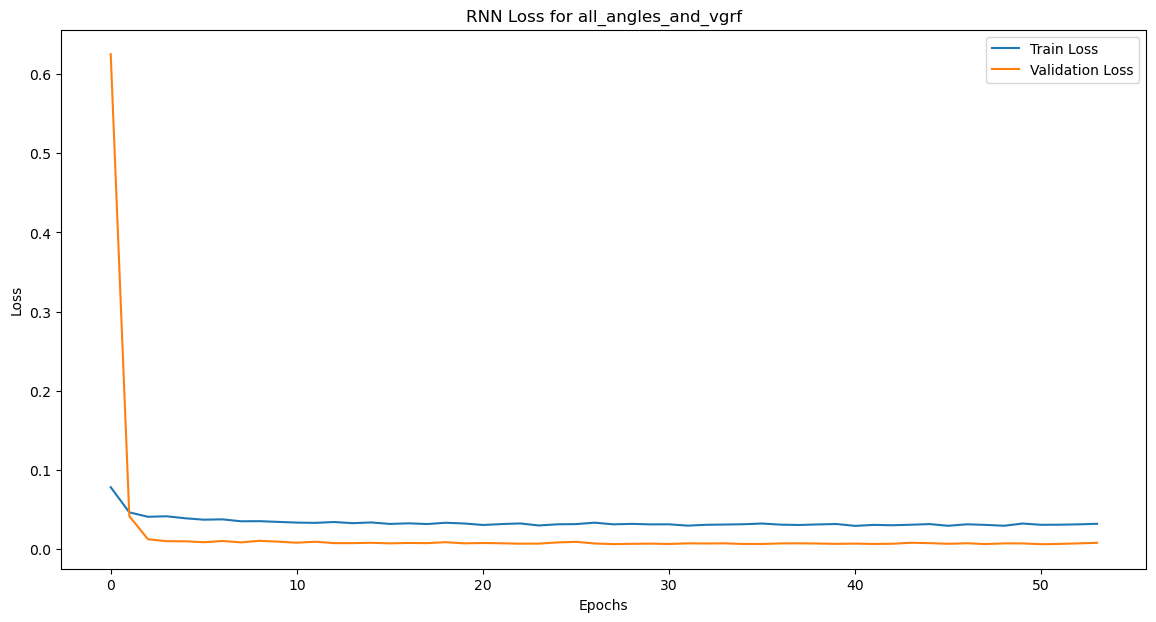

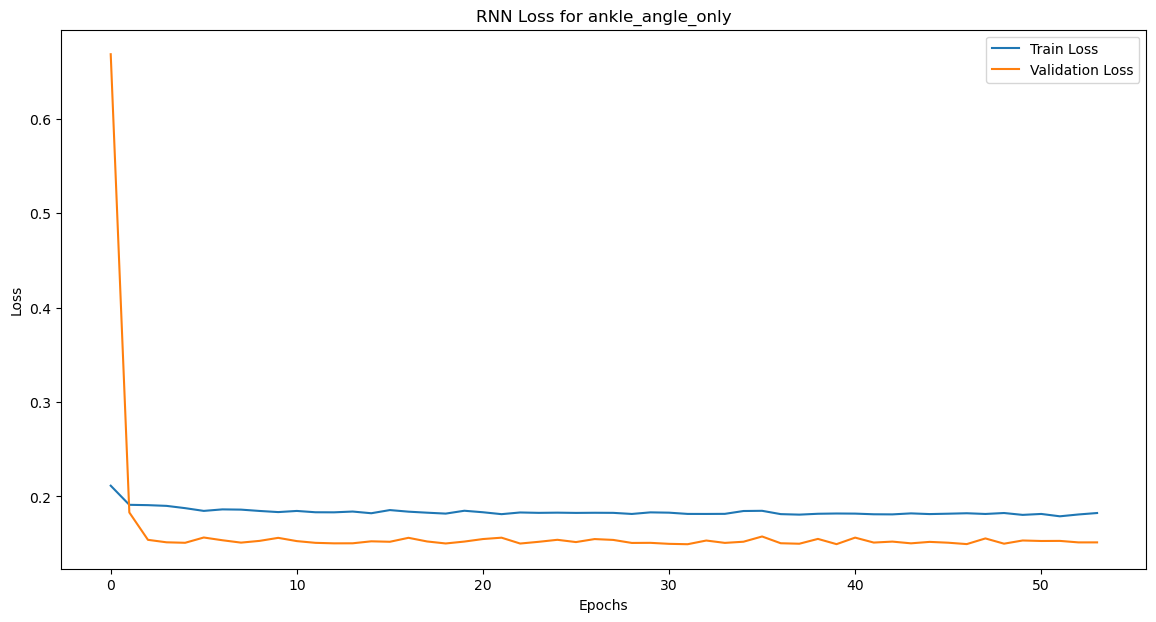

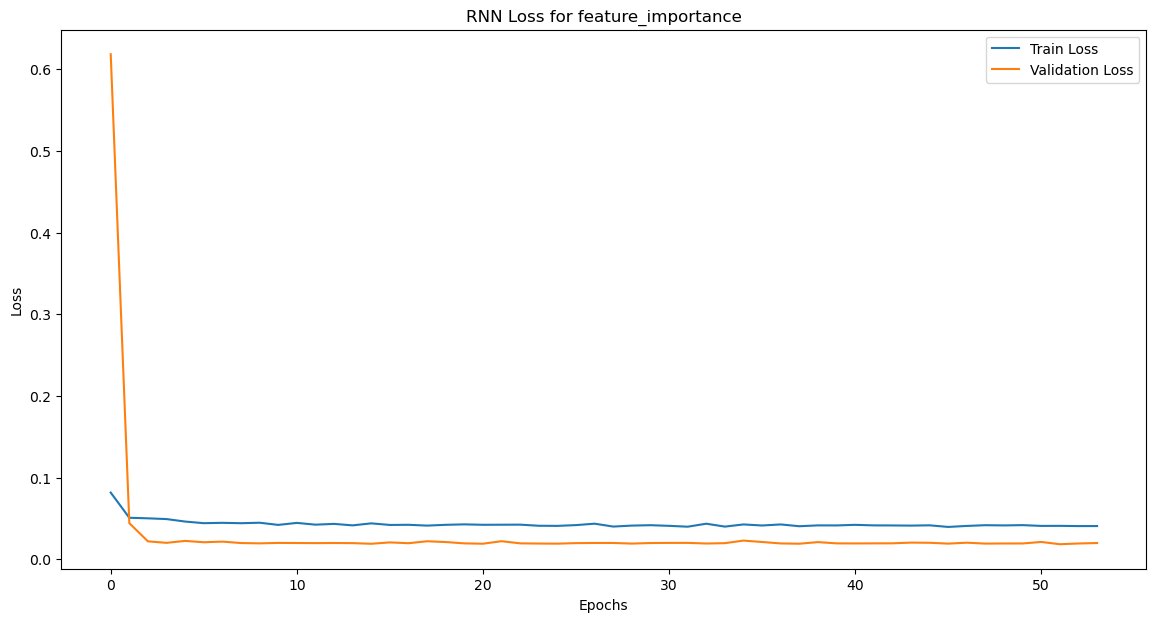

In [17]:

import matplotlib.pyplot as plt

for key, result in results.items():
    # RNN loss
    plt.figure(figsize=(14, 7))
    plt.plot(result['rnn_history'].history['loss'], label='Train Loss')
    plt.plot(result['rnn_history'].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'RNN Loss for {key}')
    plt.legend()
    plt.show()

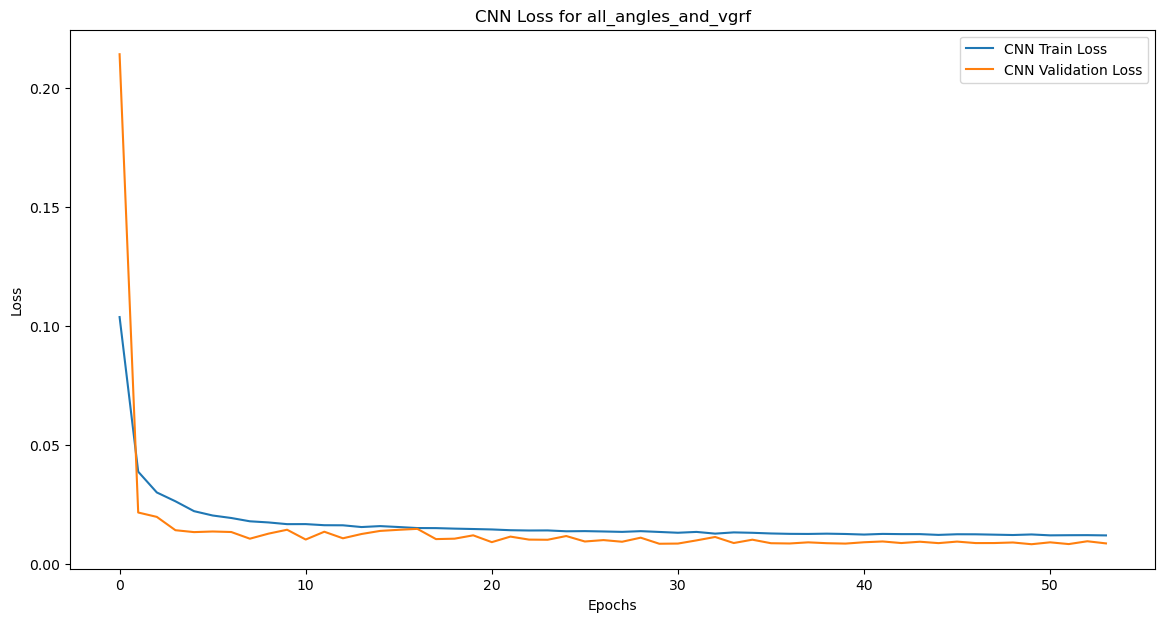

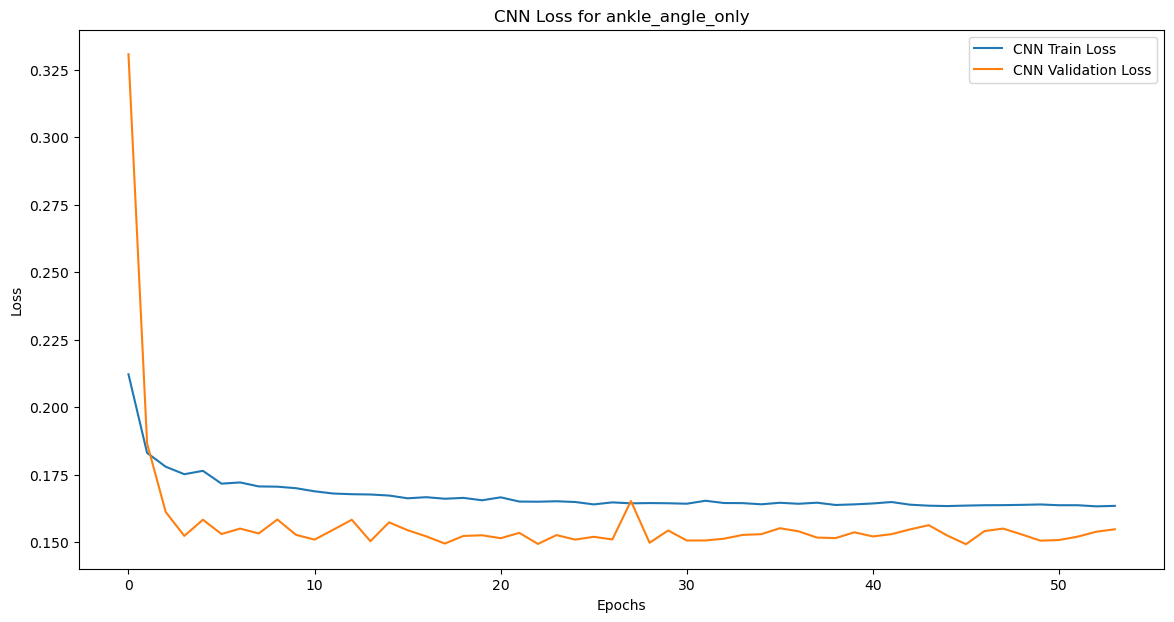

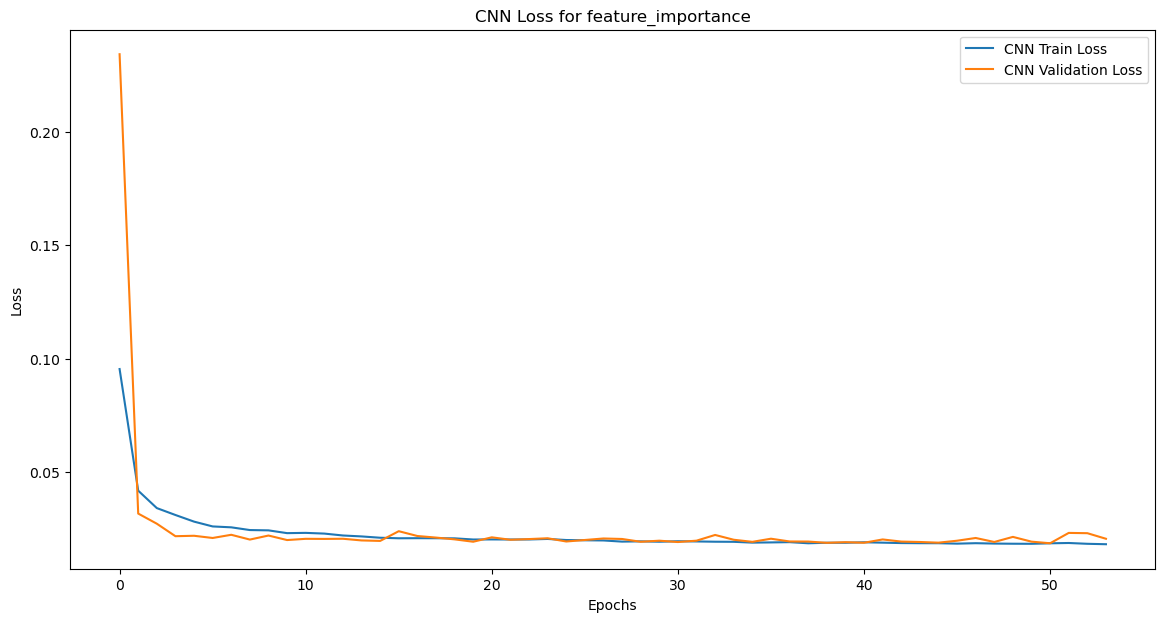

In [18]:
 # CNN loss
for key, result in results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(result['cnn_history'].history['loss'], label='CNN Train Loss')
    plt.plot(result['cnn_history'].history['val_loss'], label='CNN Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'CNN Loss for {key}')
    plt.legend()
    plt.show()

## RESULTS (ACTUAL VS PREDICTED)

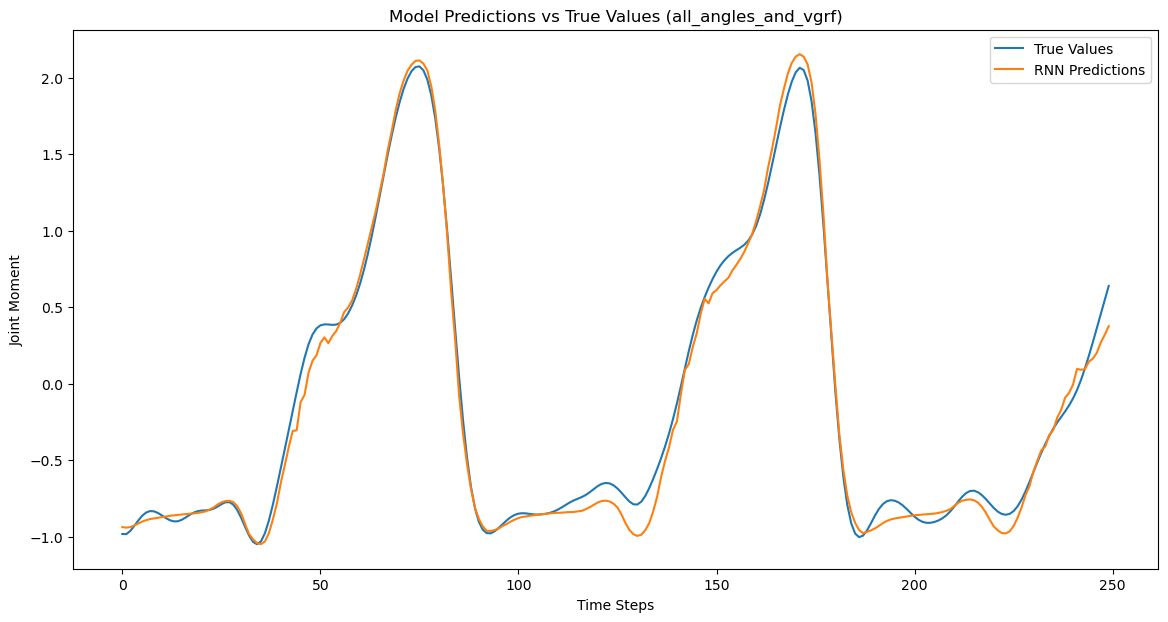

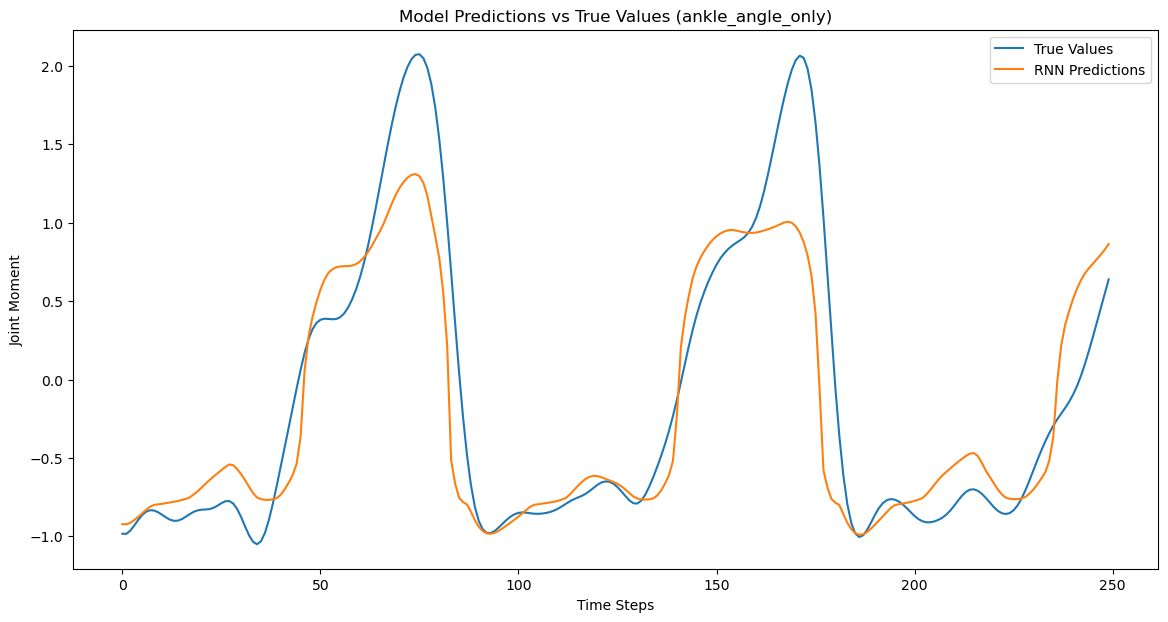

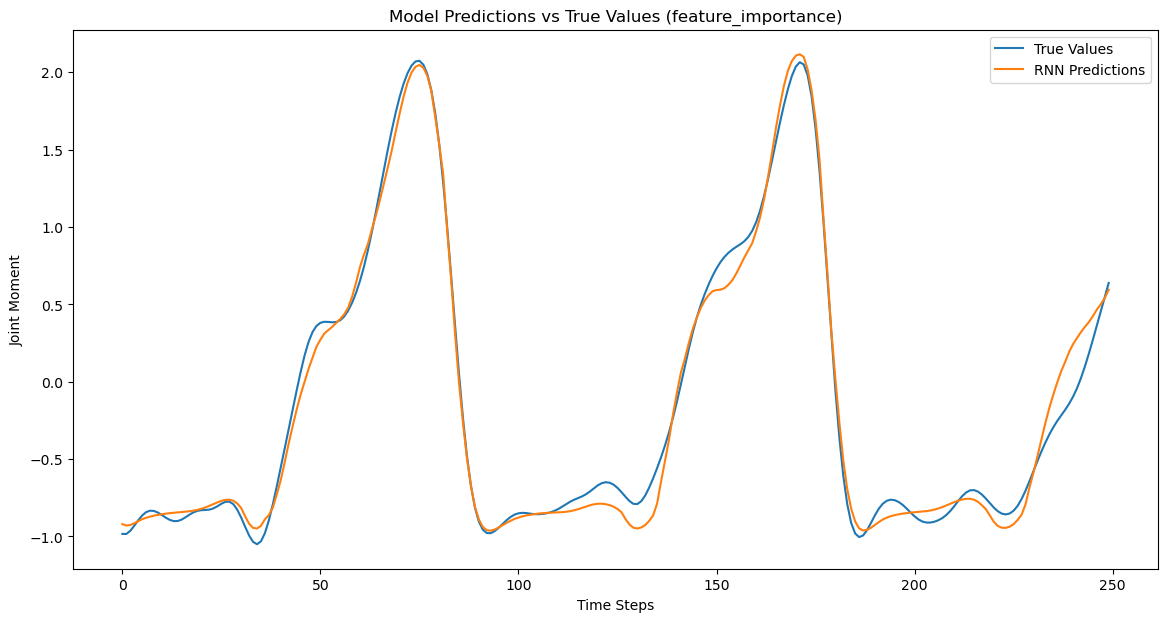

In [19]:
import matplotlib.pyplot as plt

# Number of data points to display
num_points_to_display = 250  # Adjust this number based on your preference

for key, result in results.items():
    plt.figure(figsize=(14, 7))
    
    # Select a subset of the data
    Y_testing_subset = target_Ytest_normalized.values[:num_points_to_display]
    rnn_predictions_subset = result['rnn_predictions'][:num_points_to_display]
    
    # Plot the subset of the data
    plt.plot(Y_testing_subset, label='True Values')
    plt.plot(rnn_predictions_subset, label='RNN Predictions')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Joint Moment')
    plt.title(f'Model Predictions vs True Values ({key})')
    plt.legend()
    plt.show()

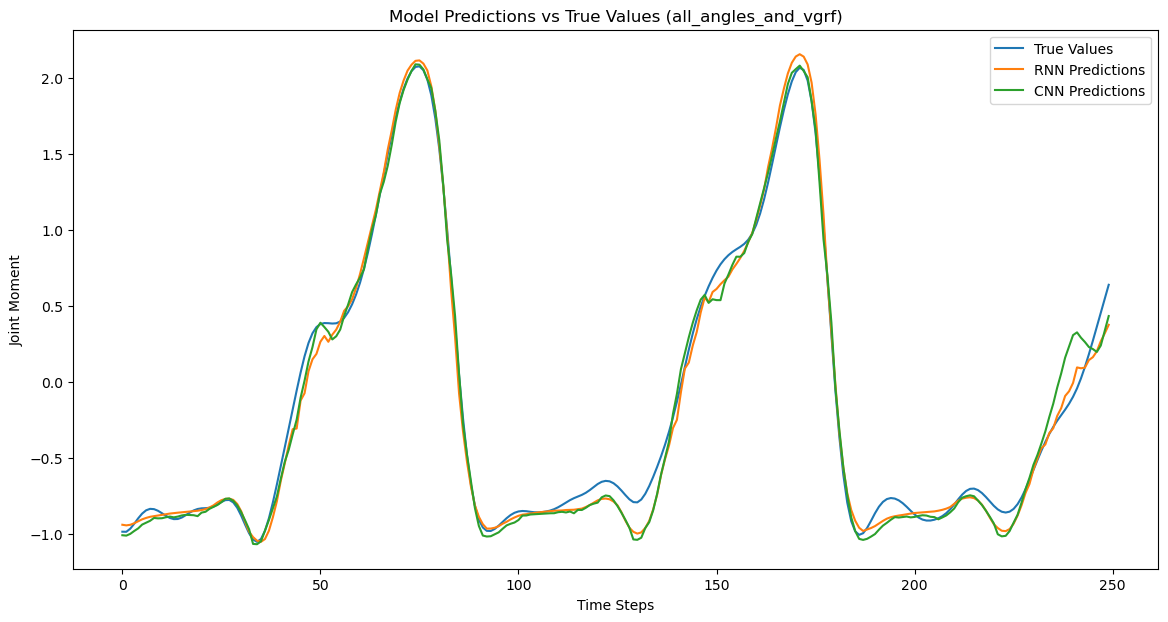

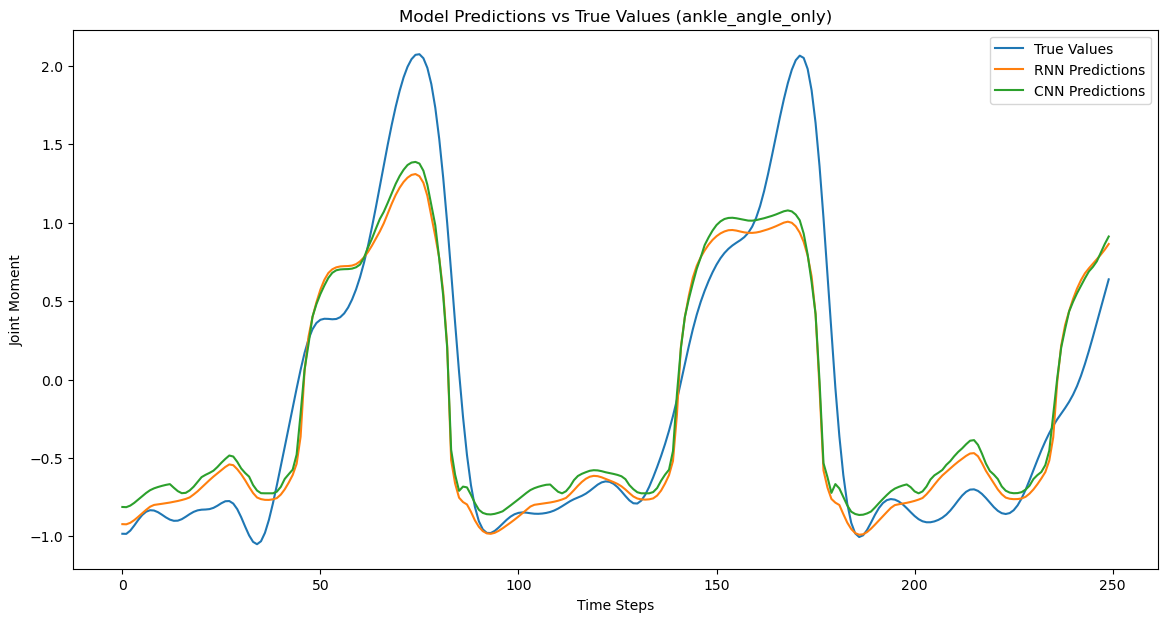

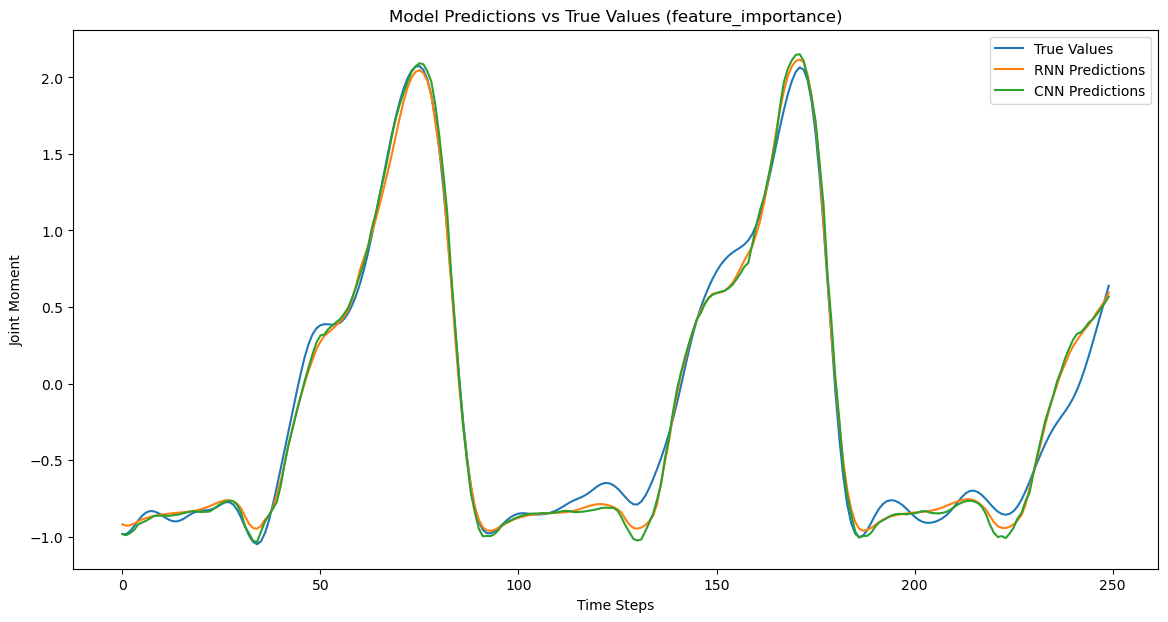

In [20]:
num_points_to_display = 250  # Adjust this number based on your preference

for key, result in results.items():
    plt.figure(figsize=(14, 7))
    
    # Select a subset of the data
    Y_testing_subset = target_Ytest_normalized.values[:num_points_to_display]
    rnn_predictions_subset = result['rnn_predictions'][:num_points_to_display]
    cnn_predictions_subset = result['cnn_predictions'][:num_points_to_display]
    
    # Plot the subset of the data
    plt.plot(Y_testing_subset, label='True Values')
    plt.plot(rnn_predictions_subset, label='RNN Predictions')
    plt.plot(cnn_predictions_subset, label='CNN Predictions')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Joint Moment')
    plt.title(f'Model Predictions vs True Values ({key})')
    plt.legend()
    plt.show()